In [4]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt

In [15]:
# Parameters
r = 1
gamma1 = 1

parameter_sets = [
    {
        'name': 'lambda_3.36',
        'lambd': 3.36251543,
        'rho': 0.19183673,
        'u0': 0.12950433,
        'output_min': 0.058579,
        'output_max': 0.259033,
        'min_delta': 1e-4,
    },
    {
        'name': 'lambda_5.85',
        'lambd': 5.84805224,
        'rho': 0.46734694,
        'u0': 0.28840600,
        'output_min': 0.127412,
        'output_max': 0.694759,
        'min_delta': 1e-3,
    },
    {
        'name': 'lambda_9.53',
        'lambd': 9.53230192,
        'rho': 0.65102041,
        'u0': 0.36987505,
        'output_min': 0.158089,
        'output_max': 1.073834,
        'min_delta': 1e-3,
    },
    {
        'name': 'lambda_19.38',
        'lambd': 19.37997763,
        'rho': 0.83469388,
        'u0': 0.42421198,
        'output_min': 0.167799,
        'output_max': 1.666294,
        'min_delta': 1e-3,
    },
    {
        'name': 'lambda_35.26',
        'lambd': 35.26398748,
        'rho': 0.92653061,
        'u0': 0.43838751,
        'output_min': 0.156112,
        'output_max': 2.256968,
        'min_delta': 1e-3,
    }
]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


RUNNING EXPERIMENTS FOR: lambda_3.36
Early stopping at epoch 615 | Best loss: 0.000056
Run: 1 / 1
Number of passed models: 1
Number of failed models: 0
Average differences for {'name': 'lambda_3.36', 'lambd': 3.36251543, 'rho': 0.19183673, 'u0': 0.12950433, 'output_min': 0.058579, 'output_max': 0.259033, 'min_delta': 0.0001}:
t=0: 0.00337670, t=0.5: 0.00471289, t=1: 0.00343753
Total Time: 0.17 min, Avg per run: 10.44 sec
------------------------------------------------------------


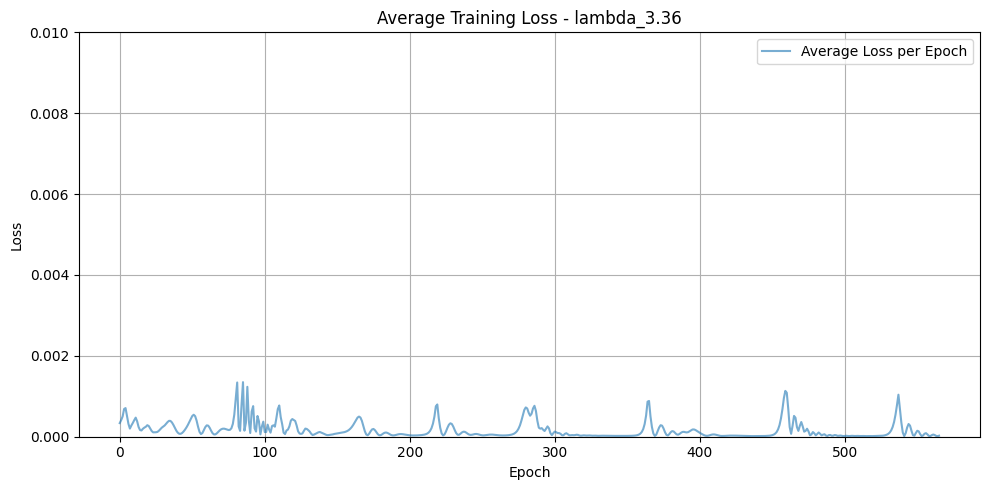

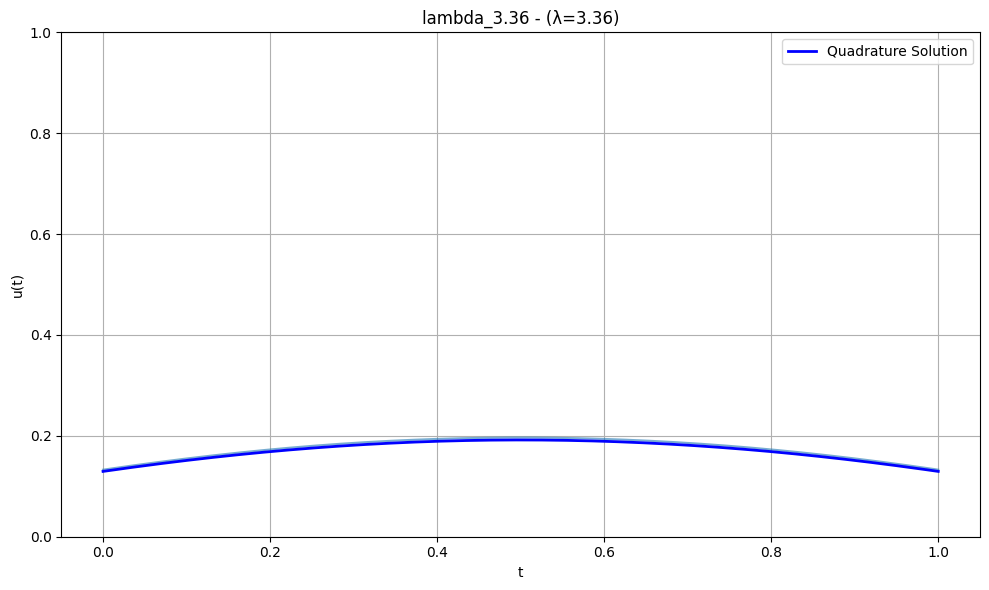


RUNNING EXPERIMENTS FOR: lambda_5.85
Early stopping at epoch 1029 | Best loss: 0.001076
Run: 1 / 1
Number of passed models: 1
Number of failed models: 0
Average differences for {'name': 'lambda_5.85', 'lambd': 5.84805224, 'rho': 0.46734694, 'u0': 0.288406, 'output_min': 0.127412, 'output_max': 0.694759, 'min_delta': 0.001}:
t=0: 0.00050582, t=0.5: 0.00140652, t=1: 0.00065710
Total Time: 0.32 min, Avg per run: 19.07 sec
------------------------------------------------------------


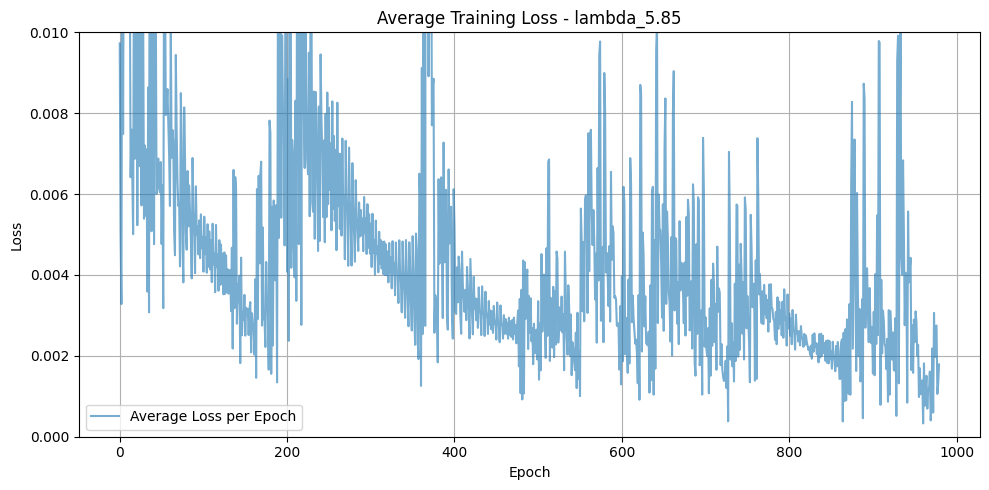

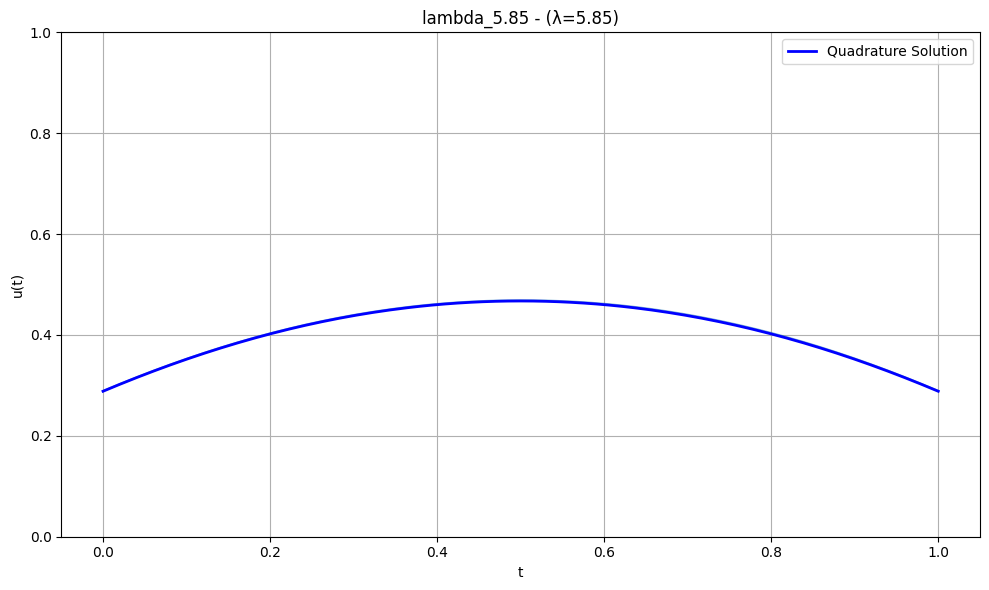


RUNNING EXPERIMENTS FOR: lambda_9.53
Early stopping at epoch 1473 | Best loss: 0.002182
Run: 1 / 1
Number of passed models: 1
Number of failed models: 0
Average differences for {'name': 'lambda_9.53', 'lambd': 9.53230192, 'rho': 0.65102041, 'u0': 0.36987505, 'output_min': 0.158089, 'output_max': 1.073834, 'min_delta': 0.001}:
t=0: 0.00059446, t=0.5: 0.00071150, t=1: 0.00257524
Total Time: 0.44 min, Avg per run: 26.10 sec
------------------------------------------------------------


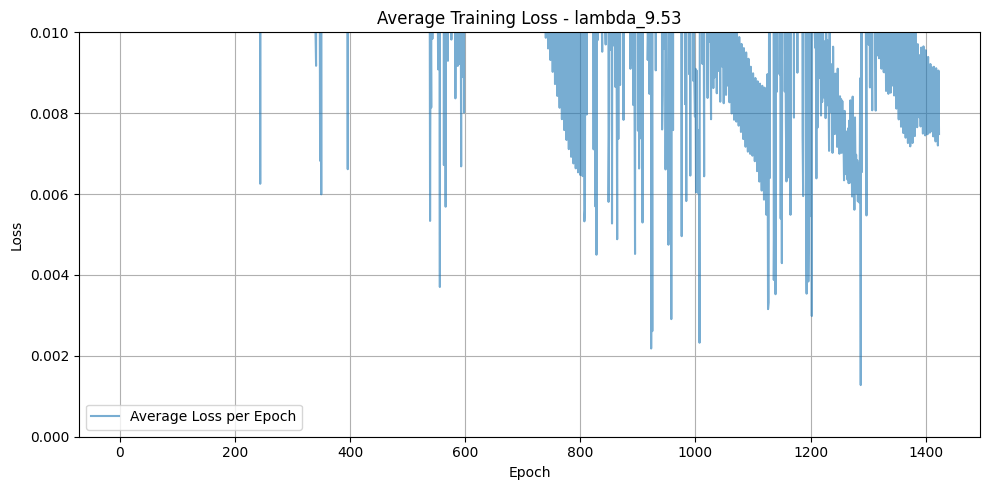

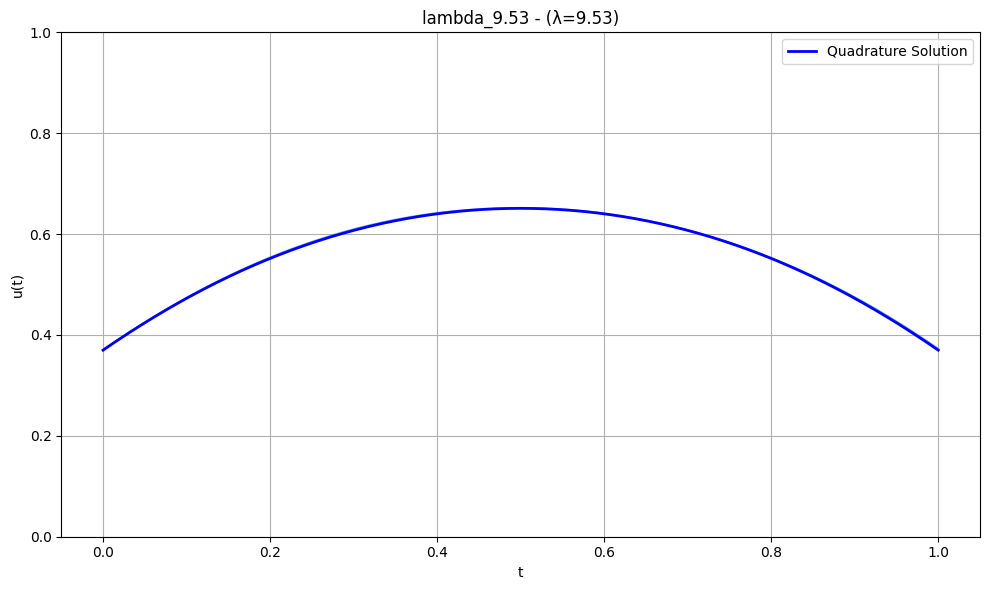


RUNNING EXPERIMENTS FOR: lambda_19.38
Early stopping at epoch 1863 | Best loss: 0.002656
Run: 1 / 1
Number of passed models: 1
Number of failed models: 0
Average differences for {'name': 'lambda_19.38', 'lambd': 19.37997763, 'rho': 0.83469388, 'u0': 0.42421198, 'output_min': 0.167799, 'output_max': 1.666294, 'min_delta': 0.001}:
t=0: 0.00181553, t=0.5: 0.00156841, t=1: 0.00318006
Total Time: 0.54 min, Avg per run: 32.21 sec
------------------------------------------------------------


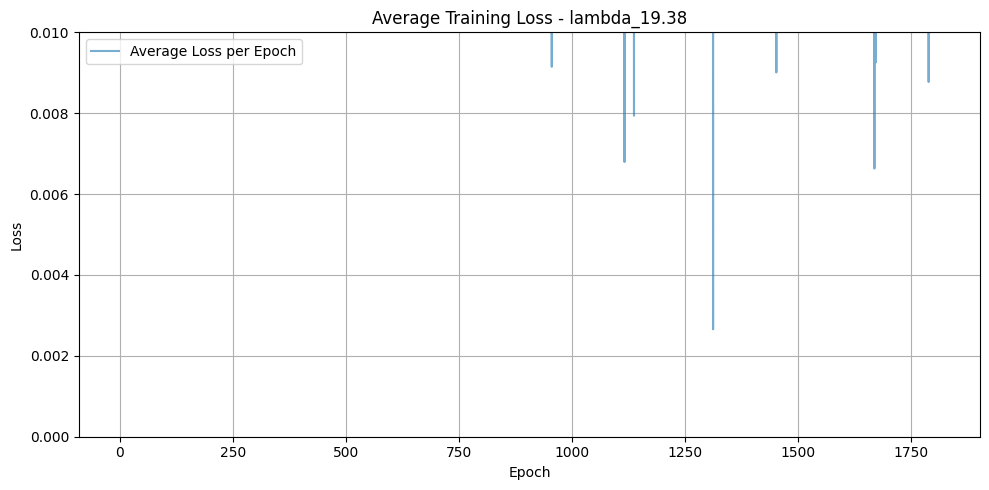

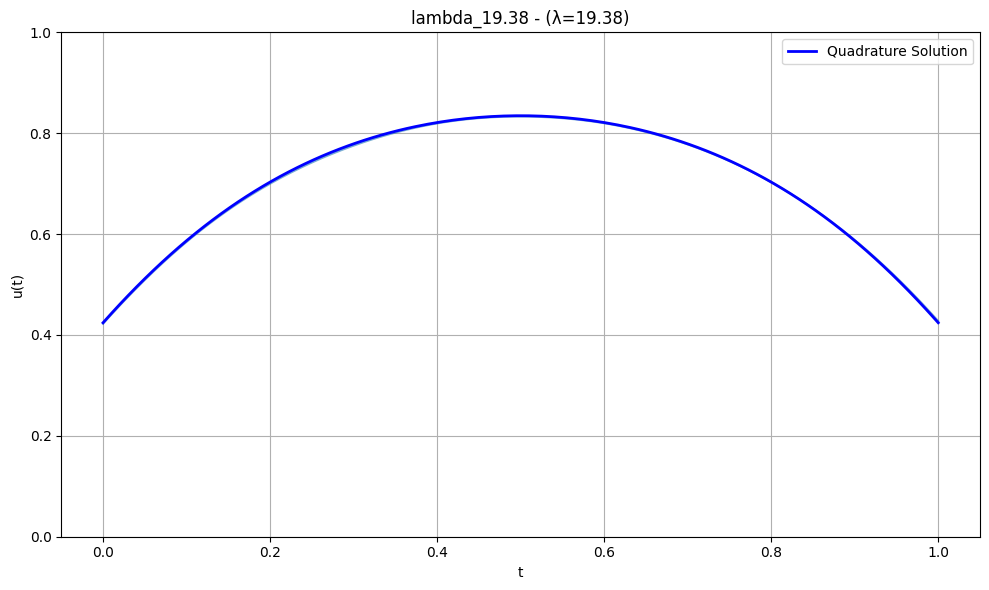


RUNNING EXPERIMENTS FOR: lambda_35.26
Early stopping at epoch 2267 | Best loss: 0.008208
Run: 1 / 1
Number of passed models: 1
Number of failed models: 0
Average differences for {'name': 'lambda_35.26', 'lambd': 35.26398748, 'rho': 0.92653061, 'u0': 0.43838751, 'output_min': 0.156112, 'output_max': 2.256968, 'min_delta': 0.001}:
t=0: 0.00351101, t=0.5: 0.00047792, t=1: 0.00010466
Total Time: 0.61 min, Avg per run: 36.63 sec
------------------------------------------------------------


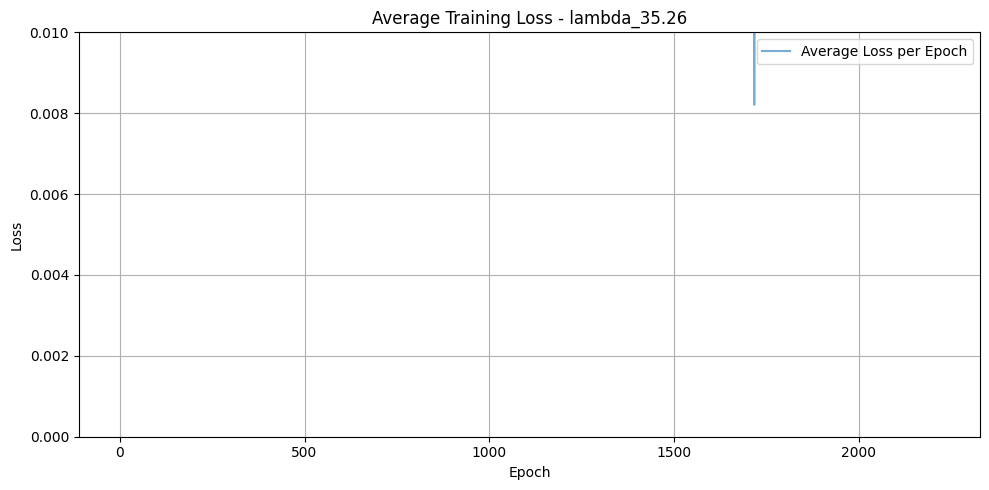

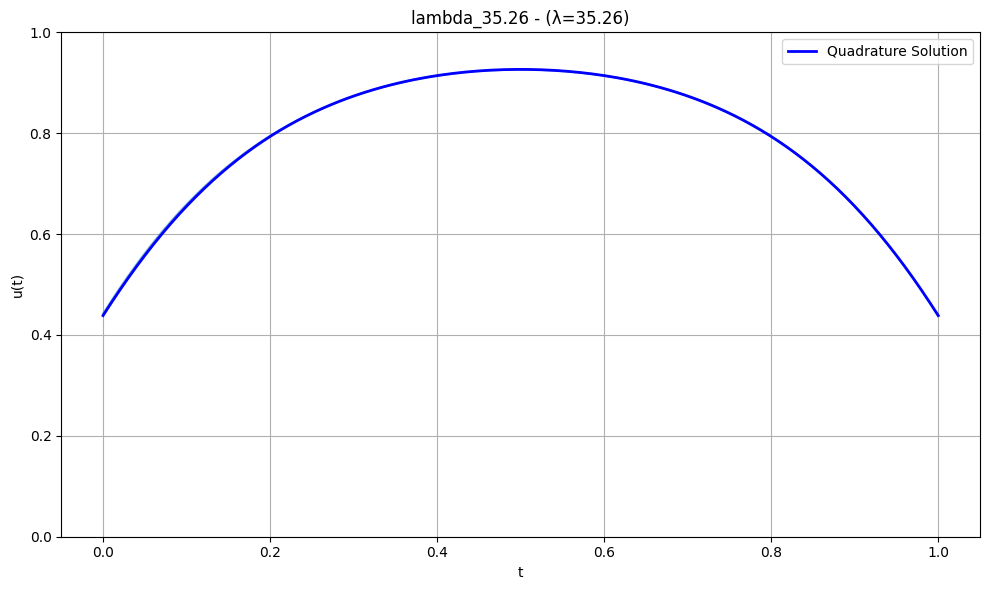


ALL EXPERIMENTS COMPLETED


In [17]:
class CosActivation(nn.Module):
    def forward(self, x):
        return 0.5 * (1 - torch.cos(2 * torch.pi * x))


class Net(nn.Module):
    def __init__(self, layer_sizes=[1, 32, 32, 32, 1], activation=CosActivation, 
                 output_min=0.058579, output_max=0.259033):
        super(Net, self).__init__()
        self.output_min = output_min
        self.output_max = output_max
        
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            if i < len(layer_sizes) - 2:
                layers.append(activation())
        
        self.hidden = nn.Sequential(*layers)
        self.output_activation = nn.Sigmoid()

    def forward(self, t):
        raw = self.hidden(t)
        return self.output_min + (self.output_max - self.output_min) * self.output_activation(raw)


def loss_function(u_pred, t, net, params):
    u_t = u_pred
    u_t_grad = torch.autograd.grad(u_pred, t, torch.ones_like(u_pred), create_graph=True)[0]
    u_t_grad2 = torch.autograd.grad(u_t_grad, t, torch.ones_like(u_t_grad), create_graph=True, allow_unused=True)[0]
    
    lambd = params['lambd']
    
    f = -u_t_grad2 - lambd * r * u_t * (1 - u_t)
    loss_eq = torch.mean(f**2)
    
    t_0 = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True, device=device)
    t_1 = torch.tensor([[1.0]], dtype=torch.float32, requires_grad=True, device=device)
    u_0 = net(t_0)
    u_1 = net(t_1)
    
    u_0_grad = torch.autograd.grad(u_0, t_0, torch.ones_like(u_0), create_graph=True)[0]
    u_1_grad = torch.autograd.grad(u_1, t_1, torch.ones_like(u_1), create_graph=True)[0]
    
    loss_bc_0 = ((-u_0_grad + torch.sqrt(torch.tensor(lambd, device=device)) * gamma1 * u_0) ** 2).mean()
    loss_bc_1 = ((u_1_grad + torch.sqrt(torch.tensor(lambd, device=device)) * gamma1 * u_1) ** 2).mean()
    
    return loss_eq, loss_bc_1, loss_bc_0


def train_model(net, optimizer, run_num, params, param_name, scheduler=None, n_epochs=3000, patience=500, min_delta=1e-5):
    t_values = torch.linspace(0, 1, 500, device=device).view(-1, 1)
    t_values.requires_grad_()
    losses = []
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        u_pred = net(t_values)
        loss_eq, loss_bc_0, loss_bc_1 = loss_function(u_pred, t_values, net, params)

        total_loss = loss_eq + loss_bc_0 + loss_bc_1

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        loss_val = total_loss.item()

        if epoch >= 50:
            losses.append(total_loss.item())
        
        if loss_val + min_delta < best_loss:
            best_loss = loss_val
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch} | Best loss: {best_loss:.6f}")
            break


    return net(t_values).detach().cpu().numpy().flatten(), losses


def F(u):
    return 0.5 * u**2 - (1/3) * u**3


def ode1(t, u, rho, lambd):
    val = 2 * lambd * r *(F(rho) - F(u))
    return np.sqrt(np.maximum(val, 0))


N_RUNS = 1
t_test = np.linspace(0, 1, 500)

# Main loop: iterate through each parameter set
for params in parameter_sets:
    print("\n" + "="*80)
    print(f"RUNNING EXPERIMENTS FOR: {params['name']}")
    print("="*80)
    
    # Extract parameters
    lambd = params['lambd']
    rho = params['rho']
    u0 = params['u0']
    output_min = params['output_min']
    output_max = params['output_max']
    min_delta = params['min_delta']
    
    # Compute quadrature solution for this parameter set
    sol1 = solve_ivp(ode1, [0, 0.5], [u0], args=(rho, lambd), 
                     dense_output=True, rtol=1e-9, atol=1e-12)
    t1 = np.linspace(0, 0.5, 100)
    u1 = sol1.sol(t1)
    t2 = 1 - t1
    u2 = u1[:, ::-1]
    
    t_quad = np.concatenate([t1, t2[::-1]])
    u_quad = np.concatenate([u1.flatten(), u2.flatten()])
    
    # Loop through layer configurations
    start_time = time.time()
    all_outputs = []
    all_losses = []
    passed_runs = 0
    failed_runs = 0

    for i in range(N_RUNS):
        net = Net(output_min=output_min, 
                    output_max=output_max).to(device)
        optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
        try:
            output, losses = train_model(net, optimizer, i+1, params, params['name'], scheduler=None, n_epochs=5000, min_delta=min_delta)
            all_outputs.append(output)
            all_losses.append(losses)
        except Exception as e:
            print(f"Run {i+1} failed: {e}")
            failed_runs += 1
            continue

        t_tensor = torch.tensor(t_test, dtype=torch.float32, device=device).unsqueeze(1)
        u_pred_test = net(t_tensor).detach().cpu().numpy().flatten()
        idx_05 = np.argmin(np.abs(t_test - 0.5))

        if abs(rho - u_pred_test[idx_05]) < 1e-2:
            passed_runs += 1
            
        else:
            failed_runs += 1

        print(f"Run: {i + 1} / {N_RUNS}", end='\r')
    
    print()  # New line after progress
    print(f"Number of passed models: {passed_runs}")
    print(f"Number of failed models: {failed_runs}")

    all_outputs = np.array(all_outputs)
    idx_05 = np.argmin(np.abs(t_test - 0.5))

    diffs_0 = [abs(u0 - output[0]) for output in all_outputs]
    diffs_05 = [abs(rho - output[idx_05]) for output in all_outputs]
    diffs_1 = [abs(u0 - output[-1]) for output in all_outputs]

    avg_diff_0 = np.mean(diffs_0)
    avg_diff_05 = np.mean(diffs_05)
    avg_diff_1 = np.mean(diffs_1)

    print(f"Average differences for {params}:")
    print(f"t=0: {avg_diff_0:.8f}, t=0.5: {avg_diff_05:.8f}, t=1: {avg_diff_1:.8f}")
    
    end_time = time.time()
    elapsed = end_time - start_time
    ave_elap = elapsed / N_RUNS
    elap_min = elapsed / 60
    print(f"Total Time: {elap_min:.2f} min, Avg per run: {ave_elap:.2f} sec")
    print("-" * 60)

    # Plot results
    all_losses = np.array(all_losses) 
    avg_losses = np.mean(all_losses, axis=0)
    plt.figure(figsize=(10, 5))
    plt.plot(avg_losses, label='Average Loss per Epoch', alpha=0.6)
    plt.title(f"Average Training Loss - {params['name']}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.ylim(0, 1e-2)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    for j, output in enumerate(all_outputs):
        plt.plot(t_test, output, alpha=0.6)
    plt.plot(t_quad, u_quad, label="Quadrature Solution", color="blue", linewidth=2)
    plt.title(f"{params['name']} - (λ={lambd:.2f})")
    plt.xlabel("t")
    plt.ylabel("u(t)")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("ALL EXPERIMENTS COMPLETED")
print("="*80)

In [4]:
# Parameters
lambd = 35.26398748
rho = 0.92653061
u0 = 0.43838751
gamma1 = 1
output_min35=0.156112
output_max35=2.256968

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Running with layers [1, 40, 60, 20, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 15
Number of failed models: 0
Average differences for with [1, 40, 60, 20, 1] layers:
Average Difference: t=0: -0.00123358, t=0.5: 0.00038946, t=1: -0.00224744
Total Training Time for [1, 40, 60, 20, 1]: 19.67 minutes, Average Train Time: 78.69 seconds


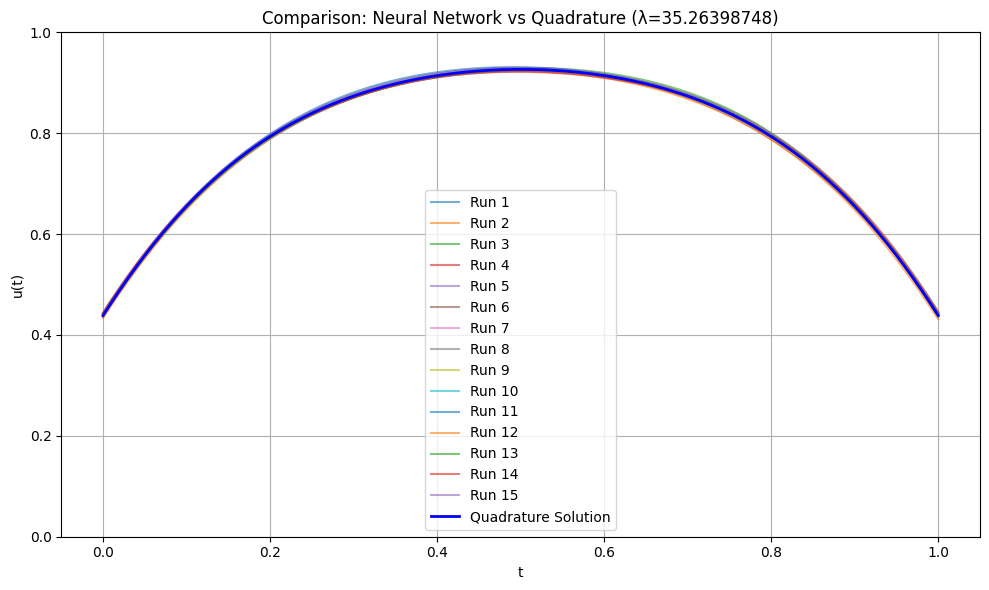

Running with layers [1, 16, 16, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 15
Number of failed models: 0
Average differences for with [1, 16, 16, 1] layers:
Average Difference: t=0: -0.00730706, t=0.5: -0.00179810, t=1: -0.00623624
Total Training Time for [1, 16, 16, 1]: 14.84 minutes, Average Train Time: 59.35 seconds


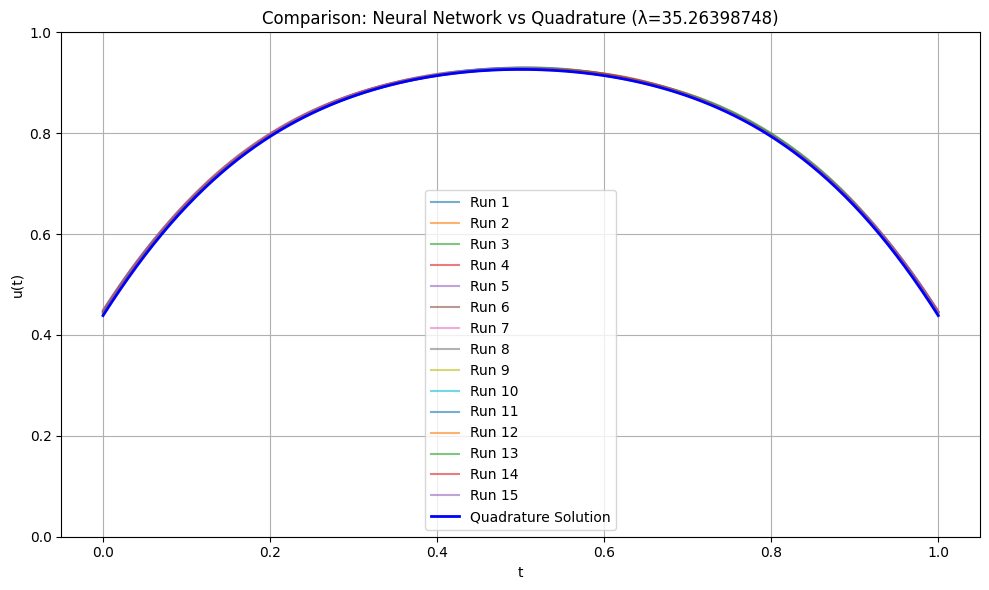

Running with layers [1, 16, 16, 16, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 15
Number of failed models: 0
Average differences for with [1, 16, 16, 16, 1] layers:
Average Difference: t=0: -0.00157605, t=0.5: -0.00020987, t=1: -0.00128052
Total Training Time for [1, 16, 16, 16, 1]: 19.30 minutes, Average Train Time: 77.21 seconds


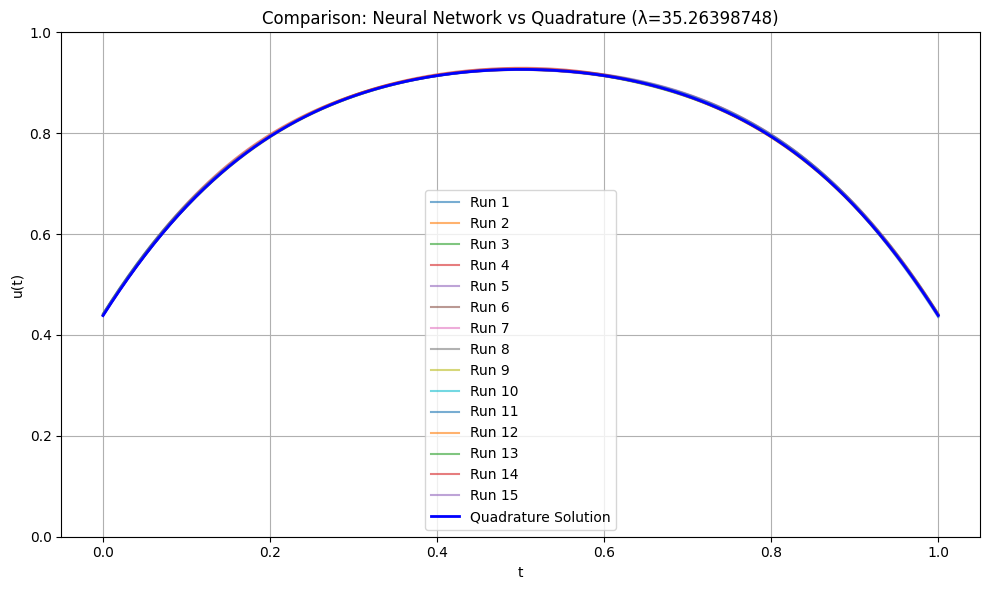

Running with layers [1, 16, 16, 16, 16, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 15
Number of failed models: 0
Average differences for with [1, 16, 16, 16, 16, 1] layers:
Average Difference: t=0: -0.00116254, t=0.5: -0.00010589, t=1: -0.00158683
Total Training Time for [1, 16, 16, 16, 16, 1]: 24.07 minutes, Average Train Time: 96.27 seconds


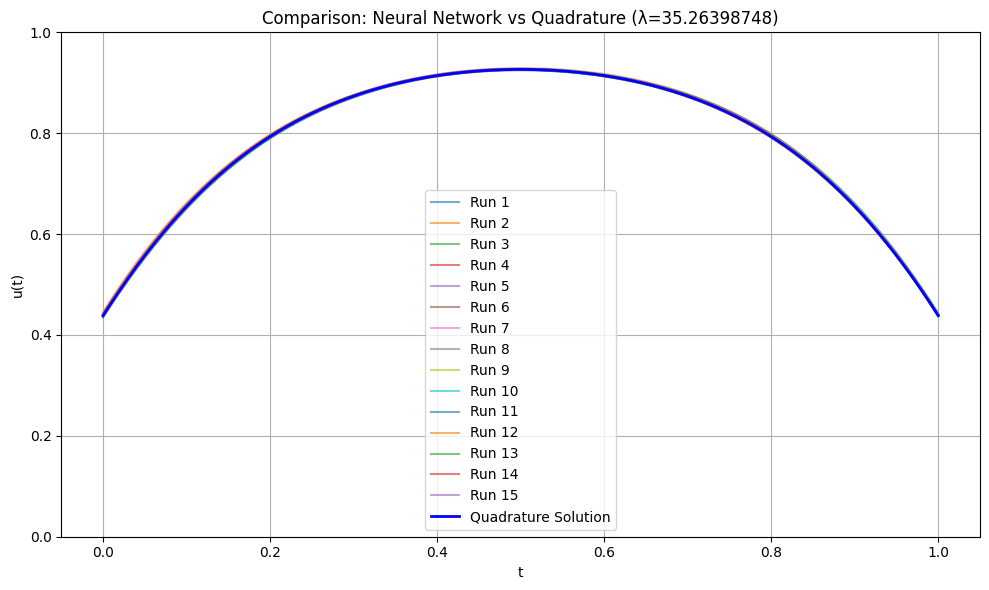

Running with layers [1, 32, 32, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 15
Number of failed models: 0
Average differences for with [1, 32, 32, 1] layers:
Average Difference: t=0: -0.00534456, t=0.5: -0.00075344, t=1: -0.00544620
Total Training Time for [1, 32, 32, 1]: 14.75 minutes, Average Train Time: 59.00 seconds


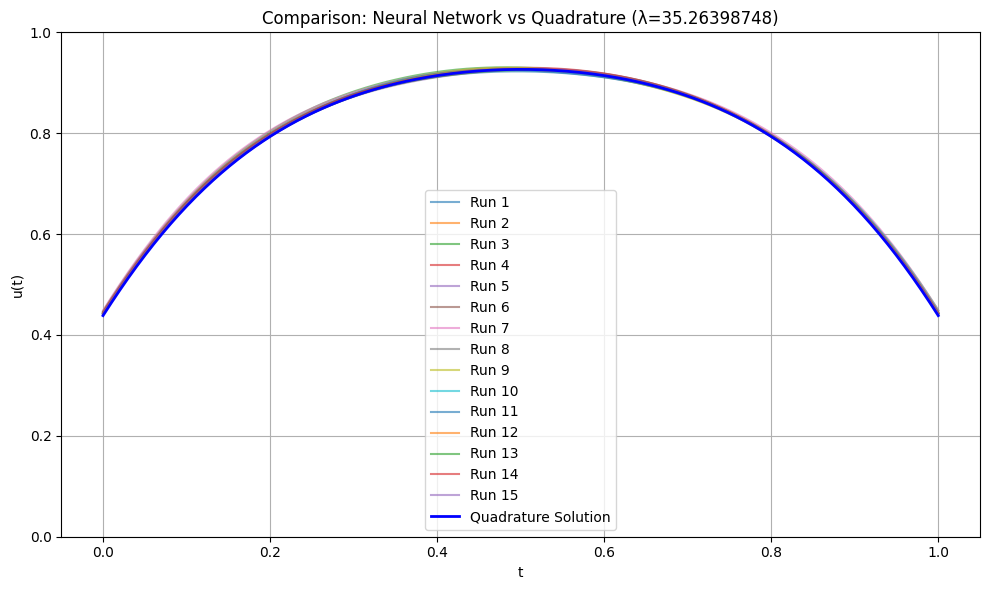

Running with layers [1, 32, 32, 32, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 15
Number of failed models: 0
Average differences for with [1, 32, 32, 32, 1] layers:
Average Difference: t=0: -0.00170050, t=0.5: -0.00013184, t=1: -0.00071098
Total Training Time for [1, 32, 32, 32, 1]: 19.36 minutes, Average Train Time: 77.43 seconds


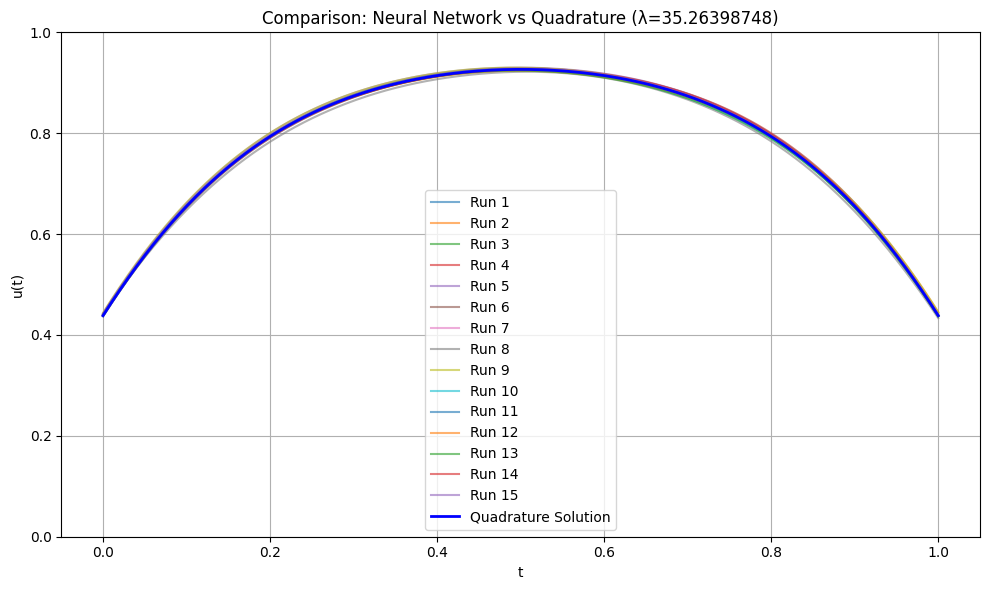

Running with layers [1, 32, 32, 32, 32, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 15
Number of failed models: 0
Average differences for with [1, 32, 32, 32, 32, 1] layers:
Average Difference: t=0: -0.00056302, t=0.5: 0.00041162, t=1: -0.00060801
Total Training Time for [1, 32, 32, 32, 32, 1]: 24.13 minutes, Average Train Time: 96.51 seconds


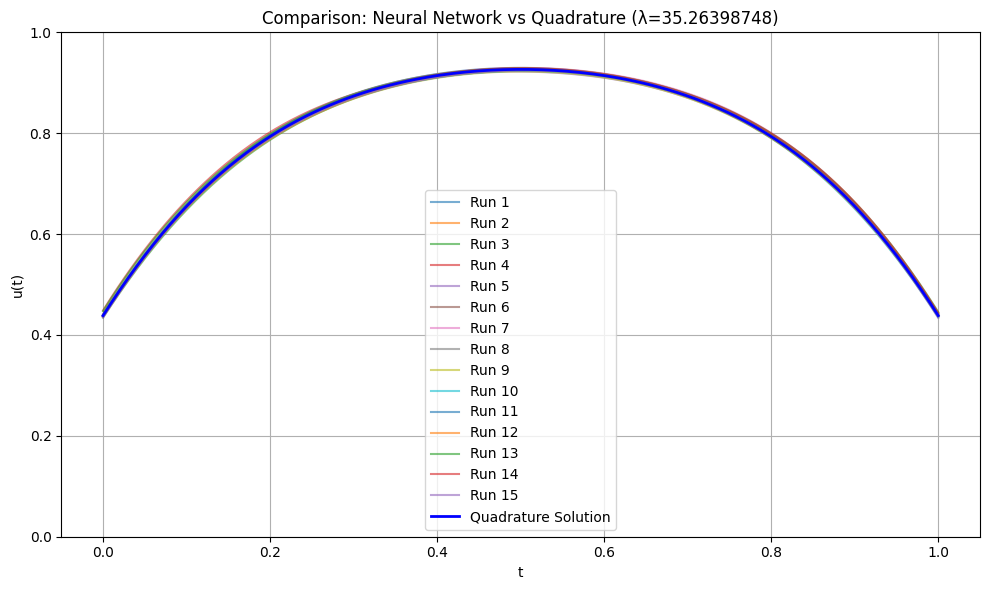

Running with layers [1, 64, 64, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 15
Number of failed models: 0
Average differences for with [1, 64, 64, 1] layers:
Average Difference: t=0: -0.00188605, t=0.5: 0.00141844, t=1: -0.00167839
Total Training Time for [1, 64, 64, 1]: 14.66 minutes, Average Train Time: 58.63 seconds


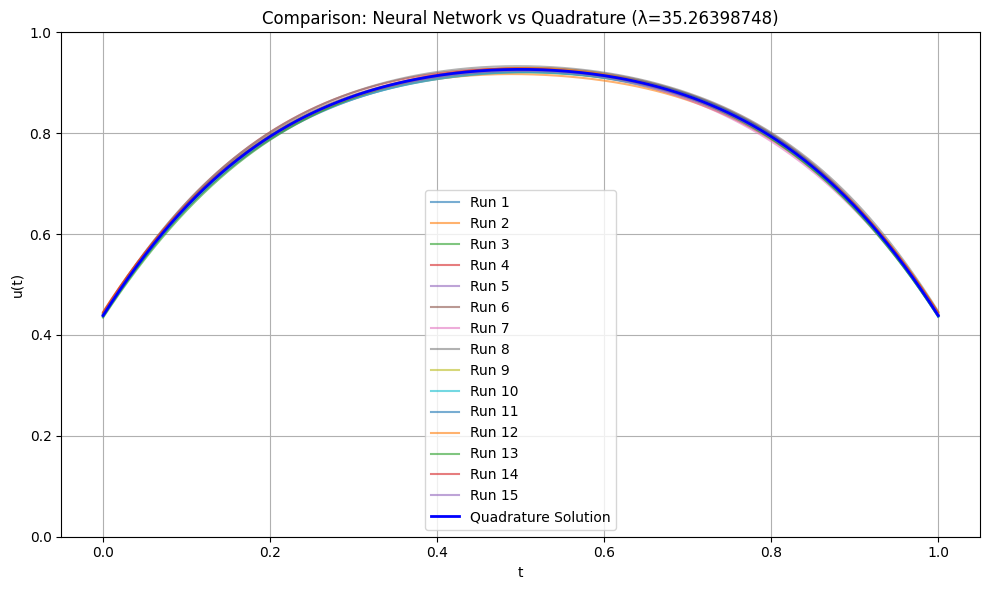

Running with layers [1, 64, 64, 64, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 14
Number of failed models: 1
Average differences for with [1, 64, 64, 64, 1] layers:
Average Difference: t=0: -0.00042374, t=0.5: -0.00198713, t=1: -0.00195453
Total Training Time for [1, 64, 64, 64, 1]: 19.29 minutes, Average Train Time: 77.16 seconds


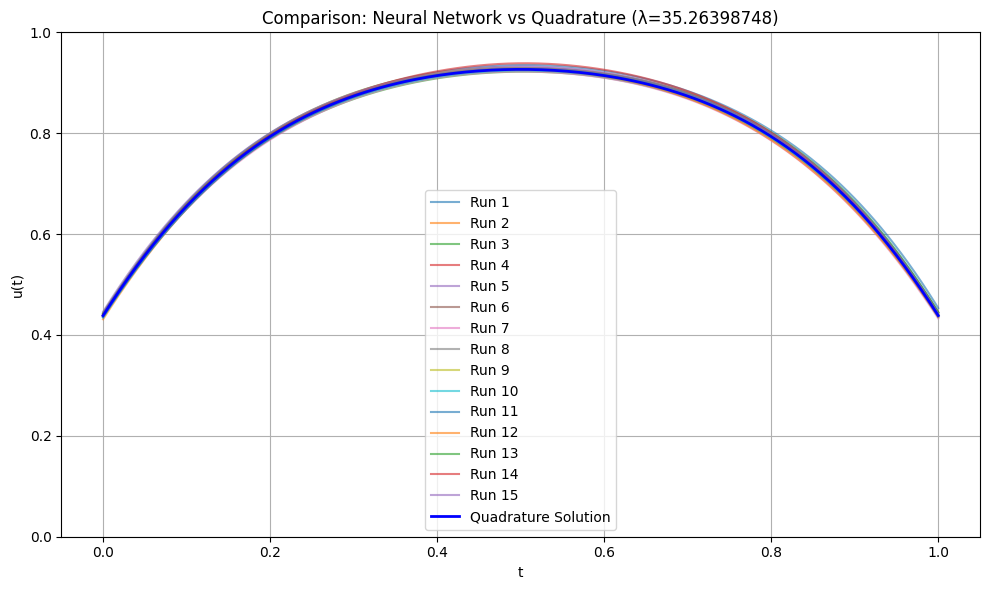

Running with layers [1, 64, 64, 64, 64, 1]
Run: 1 / 15
Run: 2 / 15
Run: 3 / 15
Run: 4 / 15
Run: 5 / 15
Run: 6 / 15
Run: 7 / 15
Run: 8 / 15
Run: 9 / 15
Run: 10 / 15
Run: 11 / 15
Run: 12 / 15
Run: 13 / 15
Run: 14 / 15
Run: 15 / 15
Number of passed models: 15
Number of failed models: 0
Average differences for with [1, 64, 64, 64, 64, 1] layers:
Average Difference: t=0: -0.00238676, t=0.5: -0.00154338, t=1: -0.00206516
Total Training Time for [1, 64, 64, 64, 64, 1]: 24.29 minutes, Average Train Time: 97.17 seconds


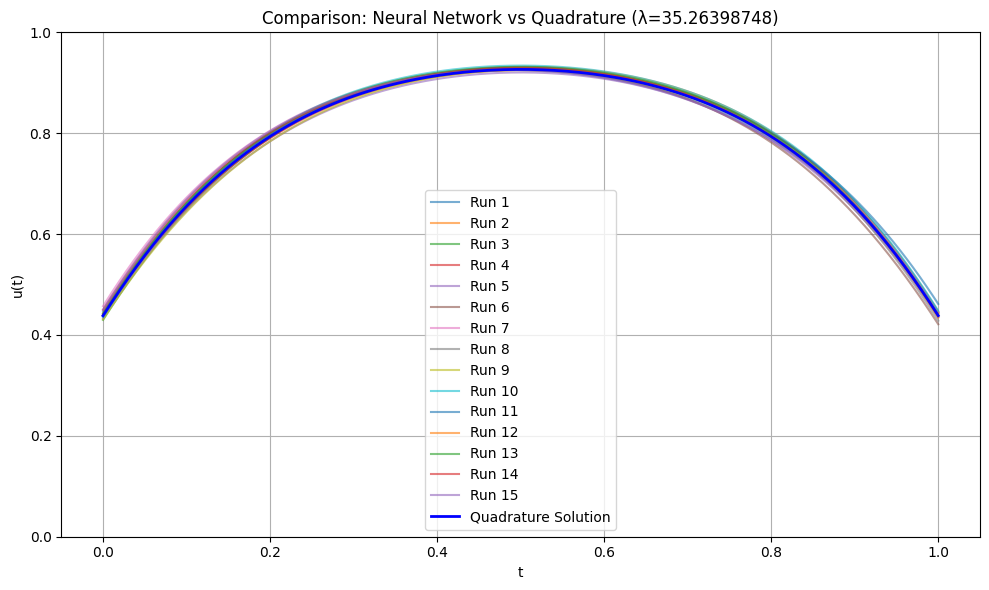

In [5]:

class CosActivation(nn.Module):
    def forward(self, x):
        return 0.5 * (1 - torch.cos(2 * np.pi * x))

# Step 1: Define the neural network
class Net(nn.Module):
    def __init__(self, layer_sizes=[1, 40, 60, 20, 1], activation=CosActivation, 
                 output_min=0.156112, output_max=2.256968):
        """
        Args:
            layer_sizes: List of integers defining the size of each layer.
                        First element is input size, last is output size.
                        Example: [1, 40, 60, 20, 1] creates 4 layers
            activation: Activation function class (e.g., nn.GELU, nn.ReLU)
            output_min: Minimum value for output scaling
            output_max: Maximum value for output scaling
        """
        super(Net, self).__init__()
        
        # Store scaling parameters
        self.output_min = output_min
        self.output_max = output_max
        
        # Build layers dynamically
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            # Add activation after all layers except the last
            if i < len(layer_sizes) - 2:
                layers.append(activation())
        
        self.hidden = nn.Sequential(*layers)
        self.output_activation = nn.Sigmoid()

    def forward(self, t):
        raw = self.hidden(t)
        return self.output_min + (self.output_max - self.output_min) * self.output_activation(raw)

# Step 4: Loss function
def loss_function(u_pred, t, net):
    u_t = u_pred  # u(t)

    # First derivative u'(t)
    u_t_grad = torch.autograd.grad(u_pred, t, torch.ones_like(u_pred), create_graph=True)[0]

    # Second derivative u''(t)
    u_t_grad2 = torch.autograd.grad(u_t_grad, t, torch.ones_like(u_t_grad), create_graph=True, allow_unused=True)[0]

    # Define the differential equation residual: -u''(t) - lambda*u(t)(1 - u(t))
    f = -u_t_grad2 - lambd * u_t * (1 - u_t)

    # Compute the loss for the differential equation
    loss_eq = torch.mean(f**2)

    # Enforce Robin boundary conditions
    t_0 = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True, device=device)
    t_1 = torch.tensor([[1.0]], dtype=torch.float32, requires_grad=True, device=device)
    u_0 = net(t_0)
    u_1 = net(t_1)

    u_0_grad = torch.autograd.grad(u_0, t_0, torch.ones_like(u_0), create_graph=True)[0]
    u_1_grad = torch.autograd.grad(u_1, t_1, torch.ones_like(u_1), create_graph=True)[0]

    # Robin boundary conditions
    loss_bc_0 = ((-u_0_grad + torch.sqrt(torch.tensor(lambd, device=device)) * gamma1 * u_0) ** 2).mean()
    loss_bc_1 = ((u_1_grad + torch.sqrt(torch.tensor(lambd, device=device)) * gamma1 * u_1) ** 2).mean()

    return loss_eq, loss_bc_1, loss_bc_0

# Step 5: Define the training loop
def train_model(net, optimizer, layers, run_num, scheduler=None, n_epochs=3000):
    t_values = torch.linspace(0, 1, 500, device=device).view(-1, 1)
    t_values.requires_grad_()
    losses = []

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        u_pred = net(t_values)
        loss_eq, loss_bc_0, loss_bc_1 = loss_function(u_pred, t_values, net)

        total_loss = loss_eq + loss_bc_0 + loss_bc_1

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        # if epoch % 500 == 0:
        #     losses.append(total_loss.item())
        #     layers_str = '_'.join(map(str, layers))
        #     filename = f'losses_layers_{layers_str}_run_{run_num}.txt'
            
        #     with open(filename, 'w') as f:
        #         f.write('epoch,loss\n')
        #         for e, l in enumerate(losses):
        #             f.write(f'{e},{l}\n')

    # Fix: Add .cpu() before .numpy()
    return net(t_values).detach().cpu().numpy().flatten()

# Step 7: Grahping true solution using Quadrature
# Define F(u) and ODE
def F(u):
    return 0.5 * u**2 - (1/3) * u**3

def ode1(t, u, rho, lambd):
    val = 2 * lambd * (F(rho) - F(u))
    return np.sqrt(np.maximum(val, 0))

sol1 = solve_ivp(ode1, [0, 0.5], [u0], args=(rho, lambd), dense_output=True, rtol=1e-9, atol=1e-12)
t1 = np.linspace(0, 0.5, 100)
u1 = sol1.sol(t1)
t2 = 1 - t1
u2 = u1[:, ::-1]

t_quad = np.concatenate([t1, t2[::-1]])
u_quad = np.concatenate([u1.flatten(), u2.flatten()])

# 6. Run NN
N_RUNS = 15
t_test = np.linspace(0, 1, 500)

layer_sizes_configs = [
    [1, 40, 60, 20, 1],
    [1, 16, 16, 1],
    [1, 16, 16, 16, 1],
    [1, 16, 16, 16, 16, 1],
    [1, 32, 32, 1],
    [1, 32, 32, 32, 1],
    [1, 32, 32, 32, 32, 1],
    [1, 64, 64, 1],
    [1, 64, 64, 64, 1],
    [1, 64, 64, 64, 64, 1],
]

for layers in layer_sizes_configs:
    print(f"Running with layers {layers}")
    start_time = time.time()
    all_outputs = []
    passed_runs = 0
    failed_runs = 0

    for i in range(N_RUNS):
        net = Net(layer_sizes=layers, output_min=output_min35, output_max=output_max35).to(device)
        optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
        output = train_model(net, optimizer, layers, i+1, scheduler=None, n_epochs=5000)
        all_outputs.append(output)

        t_tensor = torch.tensor(t_test, dtype=torch.float32, device=device).unsqueeze(1)
        u_pred_test = net(t_tensor).detach().cpu().numpy().flatten()
        idx_05 = np.argmin(np.abs(t_test - 0.5))

        if abs(rho - u_pred_test[idx_05]) < 1e-2:
            passed_runs += 1

        else:
            failed_runs += 1

        print(f"Run: {i + 1} / {N_RUNS}")

    print(f"Number of passed models: {passed_runs}")
    print(f"Number of failed models: {failed_runs}")
    print("=" * 60)

    all_outputs = np.array(all_outputs)

    # Compute average differences at t=0, t=0.5, t=1
    diffs_0 = []
    diffs_05 = []
    diffs_1 = []

    for i in range(N_RUNS):
        output = all_outputs[i]
        diffs_0.append(u0 - output[0])
        diffs_05.append(rho - output[idx_05])
        diffs_1.append(u0 - output[-1])

    avg_diff_0 = np.mean(diffs_0)
    avg_diff_05 = np.mean(diffs_05)
    avg_diff_1 = np.mean(diffs_1)

    print(f"Average differences for with {layers} layers:")
    print(f"Average Difference: t=0: {avg_diff_0:.8f}, t=0.5: {avg_diff_05:.8f}, t=1: {avg_diff_1:.8f}")
    end_time = time.time()
    elapsed = end_time - start_time
    ave_elap = elapsed / N_RUNS
    elap_min = elapsed / 60
    print(f"Total Training Time for {layers}: {elap_min:.2f} minutes, Average Train Time: {ave_elap:.2f} seconds")
    print("=" * 60)

    # Plot Mean and Variance
    plt.figure(figsize=(10, 6))
    for i, output in enumerate(all_outputs):
        plt.plot(t_test, output, label=f'Run {i+1}', alpha=0.6)
    plt.plot(t_quad, u_quad, label="Quadrature Solution", color="blue", linewidth=2)
    plt.title(f"Comparison: Neural Network vs Quadrature (λ={lambd})")
    plt.xlabel("t")
    plt.ylabel("u(t)")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()